# Predict Loan Default using Logistic regression

## Content
0. Introduction
1. Data Exploration
2. Exploratory Data Analysis (EDA)
3. Data Pre-processing
4. Predictive Modelling
5. Project Outcomes & Conclusion

# <center>0. Introduction

# <center>1. Data Exploration

In [1]:
#Importing the basic librarires

import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display

from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression


from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
f1_score, roc_auc_score, roc_curve, precision_score, recall_score

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

In [107]:
#Importing the dataset

df = pd.read_excel('data.xlsx')
df.drop(['ID','year'],axis=1, inplace=True)

target = 'Status'
labels = ['Defaulter','Not-Defaulter']
features = [i for i in df.columns.values if i not in [target]]

original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,Neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,Secured_by,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,NaN,NaN,360.0,not_neg,not_int,not_lpsm,118000.0,sb,pr,home,1U,1740.0,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,NaN,NaN,360.0,not_neg,not_int,lpsm,NaN,sb,pr,home,1U,4980.0,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.56,0.2000,595.0,360.0,neg_amm,not_int,not_lpsm,508000.0,sb,pr,home,1U,9480.0,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.25,0.6810,NaN,360.0,not_neg,not_int,not_lpsm,658000.0,sb,pr,home,1U,11880.0,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.00,0.3042,0.0,360.0,not_neg,not_int,not_lpsm,758000.0,sb,pr,home,1U,10440.0,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0



Inference: The Datset consists of 32 features & 148670 samples.


#### >>Feature Description
-코딩북 참고해서 작성하기

In [3]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 145326 non-null  object 
 1   Gender                     148670 non-null  object 
 2   approv_in_adv              147762 non-null  object 
 3   loan_type                  148670 non-null  object 
 4   loan_purpose               148536 non-null  object 
 5   Credit_Worthiness          148670 non-null  object 
 6   open_credit                148670 non-null  object 
 7   business_or_commercial     148670 non-null  object 
 8   loan_amount                148670 non-null  int64  
 9   rate_of_interest           112231 non-null  float64
 10  Interest_rate_spread       112031 non-null  float64
 11  Upfront_charges            109028 non-null  float64
 12  term                       148629 non-null  float64
 13  Neg_ammortization          14

In [4]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

loan_limit                       2
Security_Type                    2
submission_of_application        2
co-applicant_credit_type         2
Secured_by                       2
construction_type                2
Status                           2
interest_only                    2
Neg_ammortization                2
lump_sum_payment                 2
business_or_commercial           2
open_credit                      2
approv_in_adv                    2
Credit_Worthiness                2
occupancy_type                   3
loan_type                        3
total_units                      4
Gender                           4
Region                           4
loan_purpose                     4
credit_type                      4
age                              7
term                            26
dtir1                           57
rate_of_interest               131
loan_amount                    211
property_value                 385
Credit_Score                   401
income              

In [108]:
#Checking number of unique rows in each feature

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=7:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 10 numerical & 21 categorical features.


In [6]:
#Checking the stats of all the columns

display(df.describe())

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000,5.000000
25%,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.000000,86.184211,0.000000,45.000000
max,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000,61.000000


In [109]:
#Check for empty elements

nvc = pd.DataFrame(df1.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df1.shape[0],3)*100
print(nvc)

                           Total Null Values  Percentage
loan_limit                                 0         0.0
Region                                     0         0.0
submission_of_application                  0         0.0
age                                        0         0.0
co-applicant_credit_type                   0         0.0
Credit_Score                               0         0.0
credit_type                                0         0.0
income                                     0         0.0
total_units                                0         0.0
Secured_by                                 0         0.0
occupancy_type                             0         0.0
construction_type                          0         0.0
Security_Type                              0         0.0
Status                                     0         0.0
interest_only                              0         0.0
Neg_ammortization                          0         0.0
term                           

# <center> 2. Exploratory Data Analysis (EDA)

**본격적인 EDA를 위해 variable visualizing을 통해 파악해보도록 한다**

**1. 단일변수 파악**

            Target Variable Distribution           


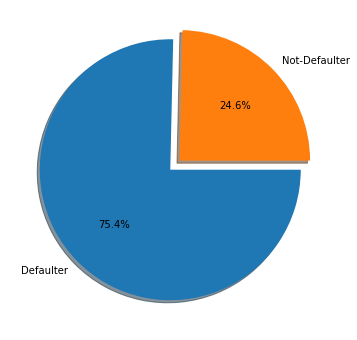

In [8]:
#Let us first analyze the distribution of the target variable

MAP={}
for e, i in enumerate(sorted(df[target].unique())):
    MAP[i]=labels[e]
#MAP={0:'Not-Survived',1:'Survived'}
df1 = df.copy()
df1[target]=df1[target].map(MAP)
explode=np.zeros(len(labels))
explode[-1]=0.1
print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(df1[target].value_counts(), labels=df1[target].value_counts().index, counterclock=False, shadow=True, 
        explode=explode, autopct='%1.1f%%', radius=1, startangle=0)
plt.show()

note : 타겟 변수는 비체납자와 체납자가 약 1:3 비율을 이루고 있다 → 추후 로지스틱 회귀분석의 더 좋은 성능을 위해서 데이터 처리를 해줘야 할 것 같음

                               Visualising Categorical Features:                                


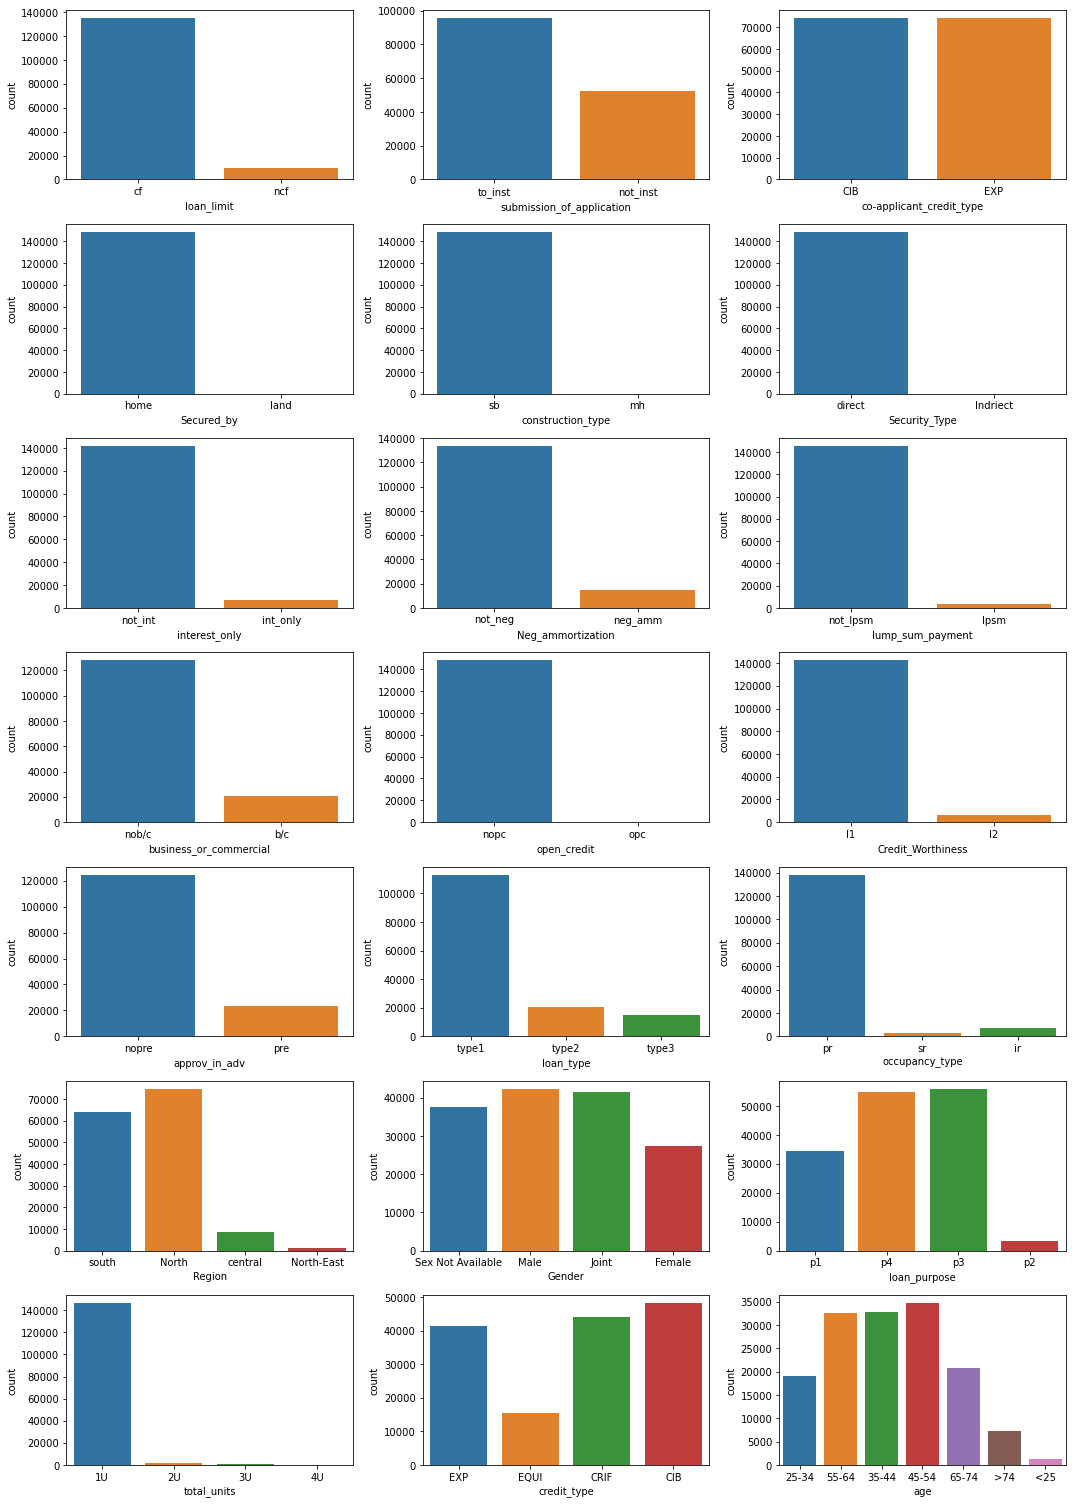

In [9]:
#Visualising the categorical features 

print('\033[1mVisualising Categorical Features:'.center(100))

n=3
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=12:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(3,1,i-1)
        sns.countplot(df[cf[i]])
plt.tight_layout()
plt.show()

**Inference:** Visualizing the categorical features reveal lot of information about the dataset.

                                     Features Distribution                                      


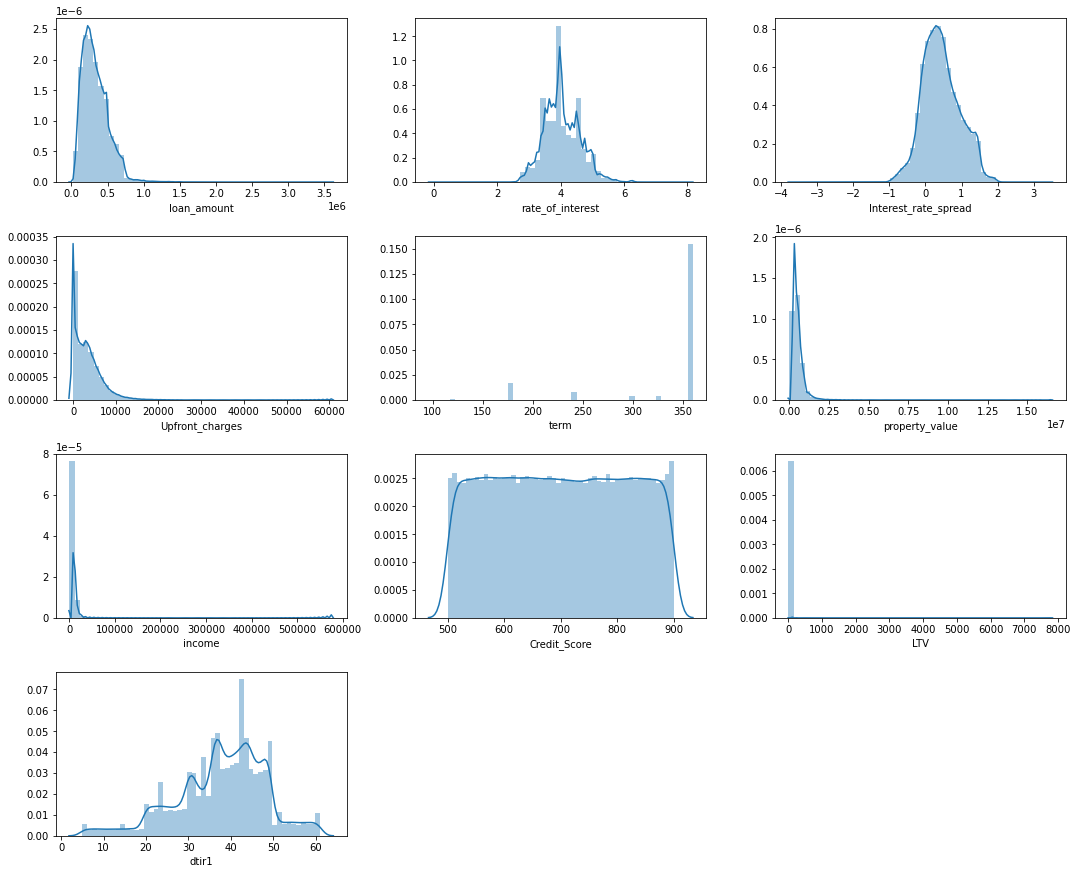

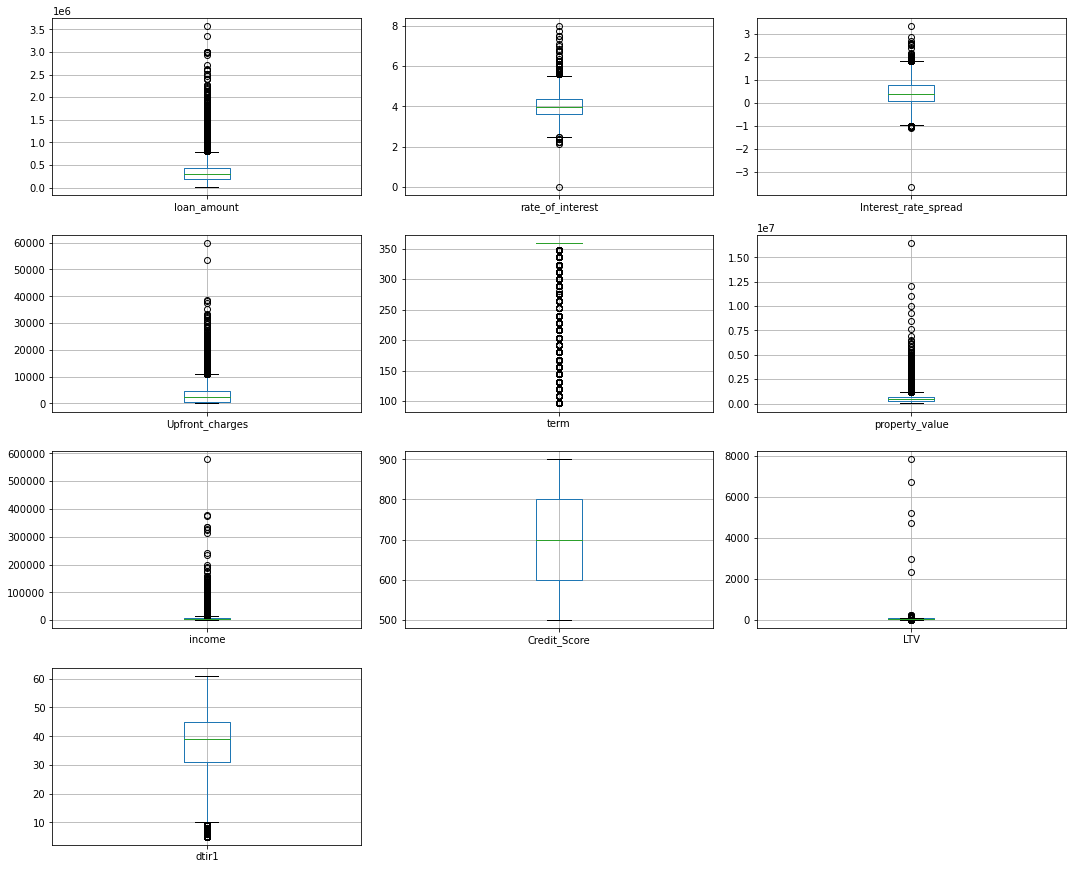

In [10]:
#Understanding the feature set

print('\033[1mFeatures Distribution'.center(100))

nf = [i for i in features if i not in cf]

plt.figure(figsize=[15,3*math.ceil(len(features)/3)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/3),3,c+1)
    sns.distplot(df[nf[c]])
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,3*math.ceil(len(features)/3)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/3),3,c+1)
    df.boxplot(nf[c])
plt.tight_layout()
plt.show()

**Inference:** The data is somewhat normally distributed. And there are many outliers present in the dataset. We shall fix these outliers..

**2. 종속 변수와 설명 변수간의 관계**

**2.1 종속 변수와 범주형 변수간의 관계**

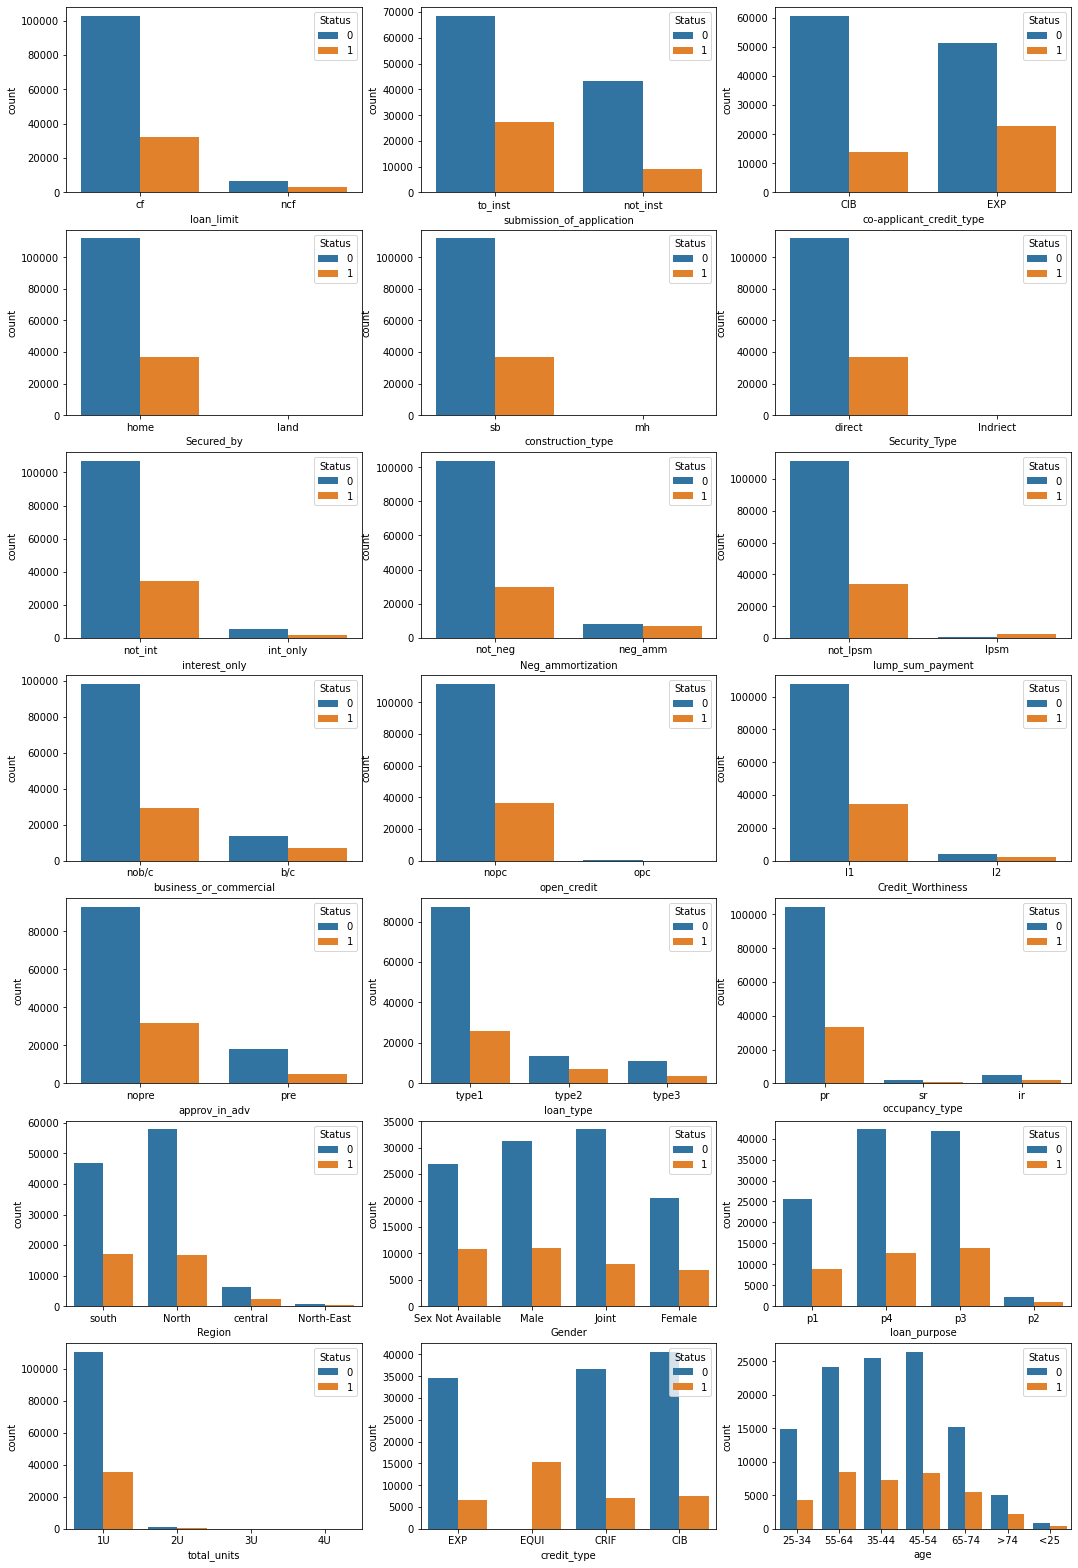

In [11]:
f, axes = plt.subplots(7,3, figsize=[18,4*math.ceil(len(cf)/n)])
axes = axes.flatten()                         
for col, ax in zip(cf, axes):
  sns.countplot(data = df, x=col, hue=target, ax=ax)
plt.show()

NOTE
- 대부분 비체납자의 비율이 체납자의 비율보다 높게 나타났다. 하지만 **credit_type 변수**에서 **'EQUI'**클래스만 체납자의 비율이 높게 나타났다.
- Equipment finance describes a loan or lease that is used to obtain business equipment. Business equipment may be any tangible asset other than real estate – examples include office furniture, computer equipment, machines used in manufacturing, medical equipment, and company vehicles.

**2.2 종속 변수와 연속형 변수간의 관계**

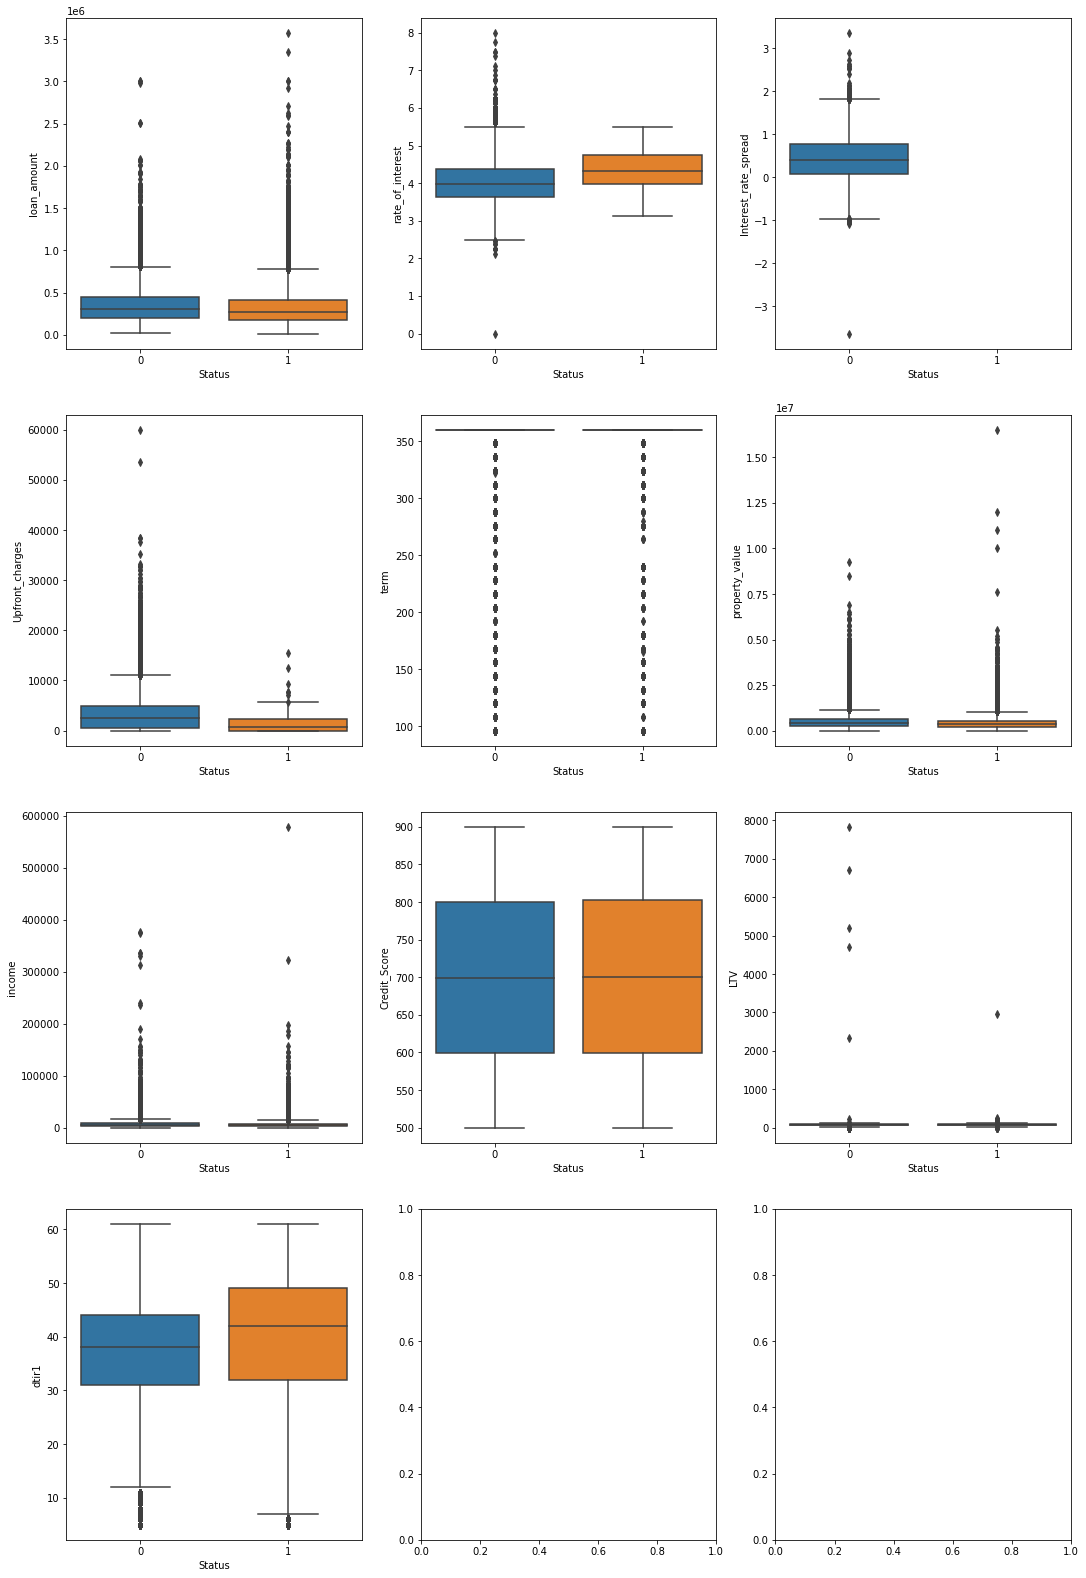

In [12]:
f, axes = plt.subplots(4,3, figsize=[18,4*math.ceil(len(cf)/n)])
axes = axes.flatten()                         
for col, ax in zip(nf, axes):
  sns.boxplot(data = df, x=target, y=col, ax=ax)
plt.show()

**3. 설명 변수간의 관계**

**3.1 연속형 변수끼리**

In [13]:
# Person 상관계수
corr = df[nf].corr(method = 'pearson')
corr

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,dtir1
loan_amount,1.000000,-0.150844,-0.377272,0.065556,0.174474,0.734249,0.456065,0.004438,0.038869,0.015029
rate_of_interest,-0.150844,1.000000,0.614908,-0.076473,0.209330,-0.122613,-0.041809,-0.001331,-0.000220,0.055124
Interest_rate_spread,-0.377272,0.614908,1.000000,0.033037,-0.157139,-0.334571,-0.151333,-0.001738,0.040257,0.078178
Upfront_charges,0.065556,-0.076473,0.033037,1.000000,-0.054960,0.053043,0.016580,-0.001484,-0.031347,0.000115
term,0.174474,0.209330,-0.157139,-0.054960,1.000000,0.045117,-0.053785,-0.003149,0.106834,0.110572
property_value,0.734249,-0.122613,-0.334571,0.053043,0.045117,1.000000,0.414883,0.002430,-0.215102,-0.056288
income,0.456065,-0.041809,-0.151333,0.016580,-0.053785,0.414883,1.000000,0.000802,-0.066203,-0.267807
Credit_Score,0.004438,-0.001331,-0.001738,-0.001484,-0.003149,0.002430,0.000802,1.000000,-0.005533,-0.000313
LTV,0.038869,-0.000220,0.040257,-0.031347,0.106834,-0.215102,-0.066203,-0.005533,1.000000,0.156557
dtir1,0.015029,0.055124,0.078178,0.000115,0.110572,-0.056288,-0.267807,-0.000313,0.156557,1.000000


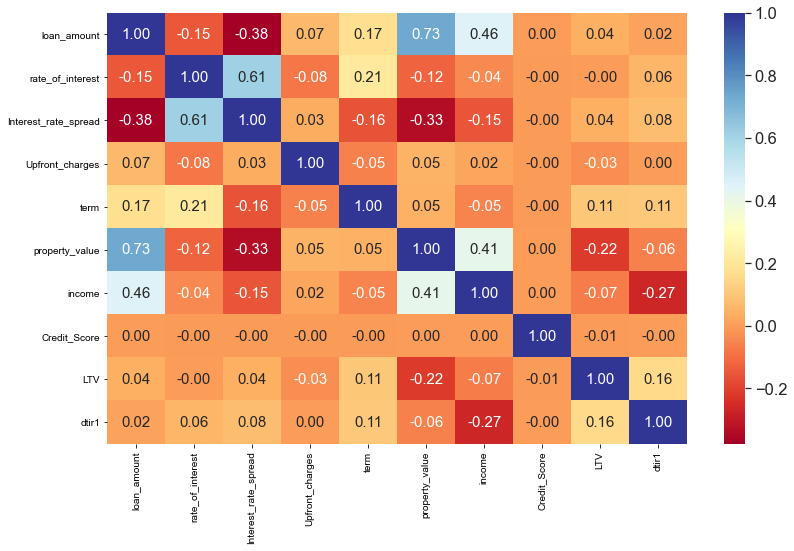

In [14]:
# heatmap (seaborn)
fig = plt.figure(figsize = (12, 8))
ax = fig.gca()

sns.set(font_scale = 1.5)  # heatmap 안의 font-size 설정
heatmap = sns.heatmap(corr.values, annot = True, fmt='.2f', annot_kws={'size':15},
                      yticklabels = nf, xticklabels = nf, ax=ax, cmap = "RdYlBu")
plt.tight_layout()
plt.show()

NOTE
- **loan_amount**와 **property_value**의 상관계수가 0.73으로 강한 상관관계를 띄고 있다.
- **Interest_rate_spread**와 **rate_of_interest**의 상관계수가 0.61로 강한 상관관계를 띄고 있다.

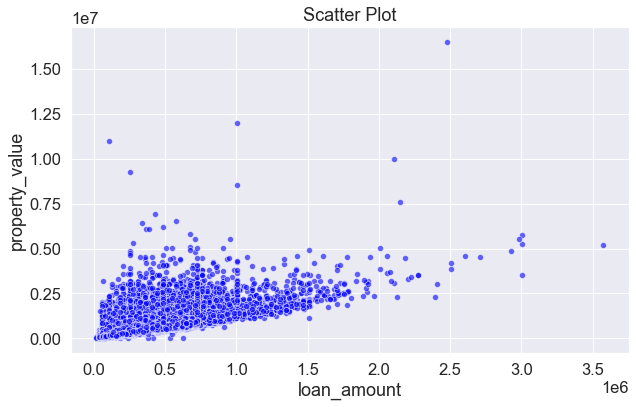

In [15]:
# scatter plot
sns.scatterplot(data=df, x='loan_amount', y='property_value', markers='o', color='blue', alpha=0.6)
plt.title('Scatter Plot')
plt.show()

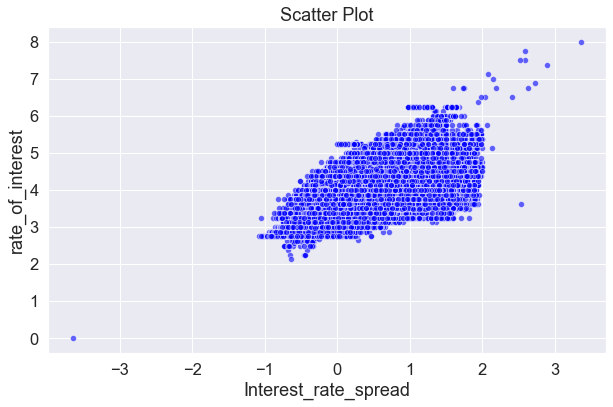

In [16]:
# scatter plot
sns.scatterplot(data=df, x='Interest_rate_spread', y='rate_of_interest', markers='o', color='blue', alpha=0.6)
plt.title('Scatter Plot')
plt.show()

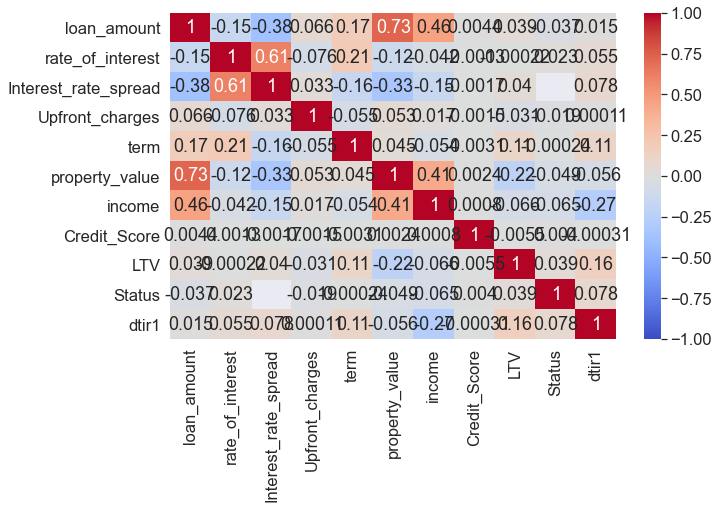

In [36]:
sns.heatmap(data= df.corr(), cmap='coolwarm', annot=True, vmax=1, vmin=-1)

# <center> 3. Data Preprocessing

In [110]:
#Removal of any Duplicate rows (if any)

counter = 0
r,c = original_df.shape

df1 = df.copy()
df1.drop_duplicates(inplace=True)
df1.reset_index(drop=True,inplace=True)

if df1.shape==(r,c):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped ---> {r-df1.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [18]:
#Check for empty elements

nvc = pd.DataFrame(df1.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df1.shape[0],3)*100
print(nvc)

                           Total Null Values  Percentage
lump_sum_payment                           0         0.0
co-applicant_credit_type                   0         0.0
total_units                                0         0.0
Secured_by                                 0         0.0
occupancy_type                             0         0.0
construction_type                          0         0.0
Status                                     0         0.0
interest_only                              0         0.0
credit_type                                0         0.0
Region                                     0         0.0
Credit_Score                               0         0.0
loan_amount                                0         0.0
business_or_commercial                     0         0.0
open_credit                                0         0.0
Credit_Worthiness                          0         0.0
loan_type                                  0         0.0
Gender                         

**Inference:** There are many outliers in the dataset.

In [111]:
#범주형 변수에 대한 결측치는 모두 삭제처리
df=df.dropna(subset=['Neg_ammortization','loan_purpose','age','submission_of_application','approv_in_adv','loan_limit'])

In [112]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

                           Total Null Values  Percentage
loan_limit                                 0         0.0
Security_Type                              0         0.0
Region                                     0         0.0
submission_of_application                  0         0.0
age                                        0         0.0
co-applicant_credit_type                   0         0.0
Credit_Score                               0         0.0
credit_type                                0         0.0
total_units                                0         0.0
Secured_by                                 0         0.0
occupancy_type                             0         0.0
construction_type                          0         0.0
Status                                     0         0.0
interest_only                              0         0.0
lump_sum_payment                           0         0.0
open_credit                                0         0.0
Gender                         

**연속형 변수의 결측치 처리**
1. 'term', 'income'는 결측률이 낮으므로 행 삭제 처리
2. 'dtir1'은 status에 대해서 크게 상이하게 나타나지 않고 결측률이 높으므로 변수 삭제 처리
3. 'LTV'와 'property_value'는 같은 행에서 결측값이 생긴다. 이때 결측률이 높으므로 그대로 놔둔다.
4. 'rate_of_interest' 와 'Interest_rate_spread'는 같은 행에서 결측값이 생기긴 하지만 앞서 확인한 heatmap에서 강한 상관관계를 띄는 것을 확인 했기 때문에 'Interest_rate_spread'를 변수 삭제처리하고 나머지 하나는 그대로 놔둔다.
5. 'Upfront_charges'는 상이한가? 상이하면 그대로 둬야하고 아니면 걍 삭제처리-> 삭제하기

In [67]:
condition = ((df['rate_of_interest'].isna()==True) & (df['Interest_rate_spread'].isna()==True))
df.loc[condition, ['rate_of_interest','Interest_rate_spread']]

,rate_of_interest,Interest_rate_spread
0,NaN,NaN
1,NaN,NaN
10,NaN,NaN
12,NaN,NaN
15,NaN,NaN
...,...,...
148651,NaN,NaN
148652,NaN,NaN
148658,NaN,NaN
148661,NaN,NaN


In [85]:
df.groupby('Status')['Upfront_charges'].describe()

,count,mean,std,min,25%,50%,75%,max
Status,,,,,,,,
0,105659.0,3231.829782,3256.058448,0.0,583.0,2603.75,4826.11,60000.0
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
df[['Status','Upfront_charges']]

,Status,Upfront_charges
0,1,NaN
1,1,NaN
2,0,595.00
3,0,NaN
4,0,0.00
...,...,...
148665,0,9960.00
148666,0,0.00
148667,0,1226.64
148668,0,4323.33


In [86]:
condition = ((df['Status']==1) & (df['Upfront_charges'].isna()==False))
df.loc[condition, ['Status','Upfront_charges']]

,Status,Upfront_charges


In [113]:
#1. 'term', 'income'는 결측률이 낮으므로 행 삭제 처리
df=df.dropna(subset=['term', 'income'])

In [114]:
#2. 'dtir1'은 status에 대해서 크게 상이하게 나타나지 않고 결측률이 높으므로 변수 삭제 처리
df=df.drop(columns=['dtir1'])

In [115]:
#3. 'rate_of_interest' 와 'Interest_rate_spread'는 같은 행에서 결측값이 생기긴 하지만 앞서 확인한 heatmap에서 강한 상관관계를 띄는 것을 확인 했기 때문에 'Interest_rate_spread'를 변수 삭제처리하고 나머지 하나는 그대로 놔둔다.
df=df.drop(columns=['Interest_rate_spread'])

In [116]:
#5. 'Upfront_charges'는 상이한가? 상이하면 그대로 둬야하고 아니면 걍 삭제처리-> 삭제하기
df=df.drop(columns=['Upfront_charges'])

In [117]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

                           Total Null Values  Percentage
loan_limit                                 0         0.0
Region                                     0         0.0
submission_of_application                  0         0.0
age                                        0         0.0
co-applicant_credit_type                   0         0.0
Credit_Score                               0         0.0
credit_type                                0         0.0
income                                     0         0.0
total_units                                0         0.0
Secured_by                                 0         0.0
occupancy_type                             0         0.0
construction_type                          0         0.0
Security_Type                              0         0.0
Status                                     0         0.0
interest_only                              0         0.0
Neg_ammortization                          0         0.0
term                           

In [118]:
print("결측치 제거 전 샘플 사이즈 : 148670, 결측치 제거 후 샘플 사이즈 : ", df.shape[0])
print("결측치 %d개 제거" %(148670 - df.shape[0]))

결측치 제거 전 샘플 사이즈 : 148670, 결측치 제거 후 샘플 사이즈 :  135108
결측치 13562개 제거


In [119]:
#Converting categorical Columns to Numeric

df1 = df.copy()
ecc = nvc[nvc['Percentage']!=0].index.values
dcc = [i for i in df.columns if i not in ecc]

#Target Variable
MAP={}
for i,e in enumerate(df1[target].unique()):
    MAP[e]=i
df1[target]=df1[target].map(MAP)
print('Mapping Target variable --->',MAP)

df3 = df1[dcc]
fcc = [i for i in cf if i not in ecc]

#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1m\nOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape

Mapping Target variable ---> {1: 0, 0: 1}

One-Hot Encoding on features:
loan_limit
submission_of_application
co-applicant_credit_type
Secured_by
construction_type
Security_Type
interest_only
Neg_ammortization
lump_sum_payment
business_or_commercial
open_credit
Credit_Worthiness
approv_in_adv

Dummy Encoding on features:
loan_type
occupancy_type
Region
Gender
loan_purpose
total_units
credit_type
age


(135108, 43)

In [120]:
df3.head()

,loan_limit,approv_in_adv,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,term,Neg_ammortization,interest_only,lump_sum_payment,construction_type,Secured_by,income,Credit_Score,co-applicant_credit_type,submission_of_application,Security_Type,Status,loan_type_type2,loan_type_type3,occupancy_type_pr,occupancy_type_sr,Region_North-East,Region_central,Region_south,Gender_Joint,Gender_Male,Gender_Sex Not Available,loan_purpose_p2,loan_purpose_p3,loan_purpose_p4,total_units_2U,total_units_3U,total_units_4U,credit_type_CRIF,credit_type_EQUI,credit_type_EXP,age_35-44,age_45-54,age_55-64,age_65-74,age_<25,age_>74
0,0,0,0,0,1,116500,360.0,1,1,1,1,0,1740.0,758,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,206500,360.0,1,1,0,1,0,4980.0,552,1,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,0,1,0,0,1,406500,360.0,0,1,1,1,0,9480.0,834,0,1,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
3,0,0,0,0,1,456500,360.0,1,1,1,1,0,11880.0,587,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
4,0,1,0,0,1,696500,360.0,1,1,1,1,0,10440.0,602,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


이상치 제거, 데이터 불균형 처리 아직 안함.

# <center> 4. Feature Selection/Extraction

In [121]:
df = df3.copy()

In [122]:
df.shape[1]

43

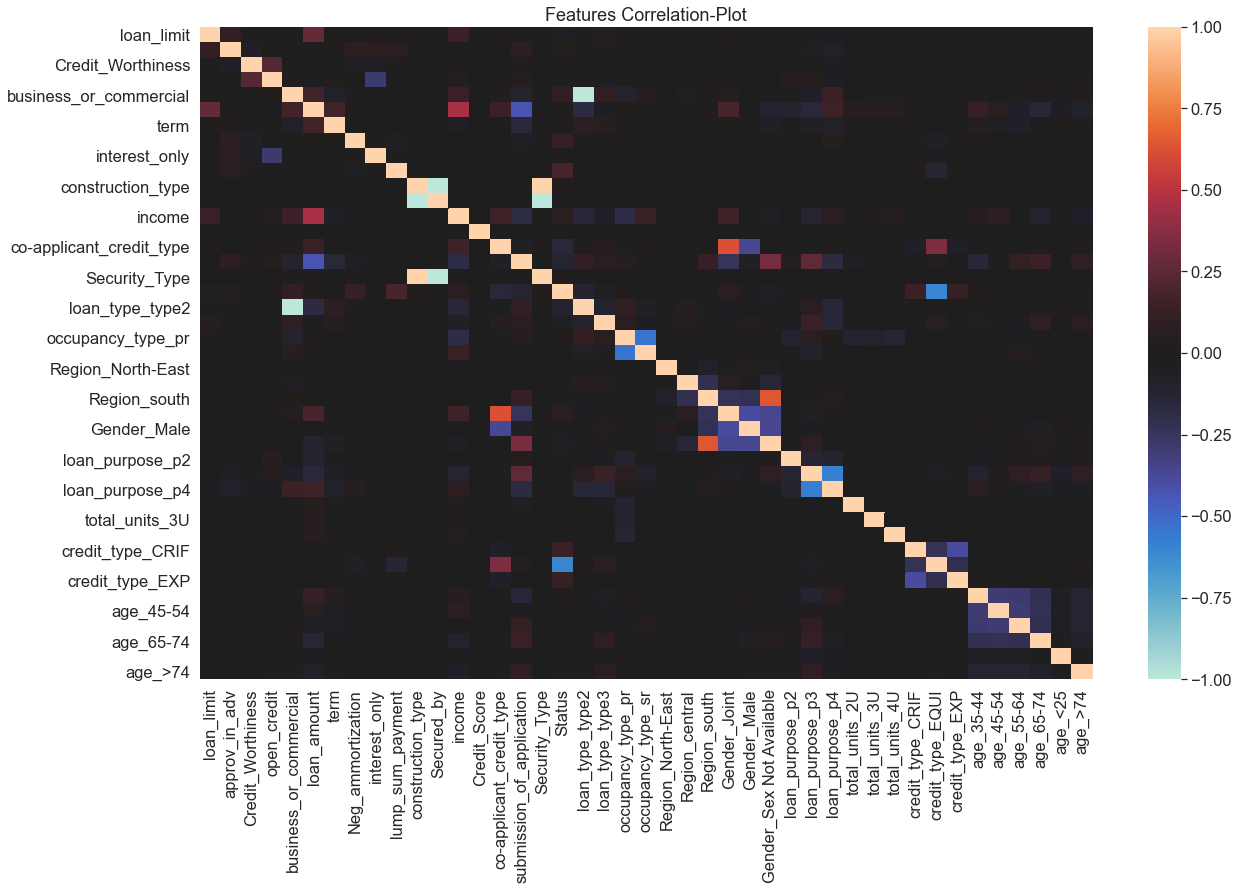

In [132]:
#Checking the correlation

features = df.columns
plt.figure(figsize=[20,12])
plt.title('Features Correlation-Plot')
sns.heatmap(df[features].corr(), vmin=-1, vmax=1, center=0) #, 
plt.show()

피쳐 셀렉션 추가해야함

# <center> 6. Logistic Regression Modeling

In [124]:
#Splitting the data intro training & testing sets

X = df.drop([target],axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (135108, 42) (135108,) 
Training set  --->  (108086, 42) (108086,) 
Testing set   --->  (27022, 42)  (27022,)


In [129]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

lr = sm.Logit(y_train, X_train).fit()

         Current function value: 0.357006
         Iterations: 35


In [126]:
print(lr.summary())

                           Logit Regression Results                           
Dep. Variable:                 Status   No. Observations:               108086
Model:                          Logit   Df Residuals:                   108046
Method:                           MLE   Df Model:                           39
Date:                Fri, 13 May 2022   Pseudo R-squ.:                  0.3686
Time:                        15:17:13   Log-Likelihood:                -38587.
converged:                      False   LL-Null:                       -61110.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
loan_limit                   -0.6332      0.035    -18.067      0.000      -0.702      -0.564
approv_in_adv                 0.2596      0.027      9.516      0.000       0.206     